In [2]:
import librosa
import numpy as np
from scipy.spatial.distance import cdist
from math import inf
from typing import Tuple
import matplotlib.pyplot as plt

In [3]:

def least_distance_mfcc(
    mfcc_reference: np.ndarray, mfcc_query: np.ndarray
) -> Tuple[int, int, float]:

    min_distance = inf
    start_index, end_index = 0, 0

    distances = cdist(mfcc_reference, mfcc_query, "euclidean")

    for i in range(0, distances.shape[0]):
        current_distance, end = calculate_min_distance(i, distances, min_distance)
        if current_distance < min_distance:
            min_distance = current_distance
            start_index = i
            end_index = end

    return start_index, end_index, min_distance


def main():
    file = r"data/ds1.wav"
    y, sr = librosa.load(file)

    REFERENCE_DURATION = 5  # in secs

    NUM_QUERIES_IN_REFERENCE = 4

    # number of samples in the reference duration
    reference_samples = REFERENCE_DURATION * sr

    # doing len(y) - reference_samples to leave out the last part, which maybe small enough to be lesser than n_fft
    for i in range(0, len(y) - reference_samples, reference_samples):

        y_reference = y[i : i + reference_samples]

        mfcc_reference = librosa.feature.mfcc(y=y_reference, sr=sr)
        """
        librosa returns an array with n_mfcc (number of mfcc's per frame)
        number of columns. having an array with the number of columns equal to the number
        of mfcc sets (number of frames) and number of rows equal to n_mfcc
        is more easy to visualise and more importantly cdist function which
        calculates the distance matrix requires that the number of rows to be
        the same for the two arrays. Hence taking a traspose.
        """
        mfcc_reference = mfcc_reference.T

        num_mfccs_in_query = mfcc_reference.shape[0] / NUM_QUERIES_IN_REFERENCE

        # for every reference, NUM_QUERIES_IN_REFERENCE queries are created.
        for j in range(0, NUM_QUERIES_IN_REFERENCE):

            # typecasting as int since query_start will be used as array index
            # and only an integer can be an array index
            query_start = int(j * num_mfccs_in_query)
            query_end = query_start + int(num_mfccs_in_query)

            mfcc_query = mfcc_reference[query_start:query_end]

            # find the best match for the query within the reference
            start_index, end_index, min_distance = least_distance_mfcc(
                mfcc_reference, mfcc_query
            )

            # expect the best match to be the query itself
            if (
                start_index != query_start
                or end_index != query_end - 1
                or min_distance != 0
            ):

                print(
                    "i %d j %d. exp start %d [got %d] end %d [got %d]. \
                      Query length %d min distance %d"
                    % (
                        i,
                        j,
                        query_start,
                        start_index,
                        query_end - 1,
                        end_index,
                        mfcc_query.shape[0],
                        min_distance,
                    )
                )

    print("DONE :")


In [6]:

def get_next_distance(
    reference_idx: int, query_idx: int, distances: np.ndarray
) -> Tuple[float, int, int]:

    distance = 0

    # Reached the end of the query
    if query_idx == distances.shape[1] - 1:
        distance = -1
    else:
        # at the end of the reference, align all the coming queries to this end
        if reference_idx == distances.shape[0] - 1:
            query_idx = query_idx + 1
            assert query_idx < distances.shape[1]
            distance = distances[reference_idx][query_idx]
        else:

            temp_distance = []
            min_dist = inf
            min_idx = -1

            # match
            temp_distance.append(distances[reference_idx + 1][query_idx + 1])
            # insert
            temp_distance.append(distances[reference_idx][query_idx + 1])
            # delete
            temp_distance.append(distances[reference_idx + 1][query_idx])

            for k in range(0, len(temp_distance)):
                if temp_distance[k] < min_dist:
                    min_dist = temp_distance[k]
                    min_idx = k

            if min_idx == 0:
                reference_idx, query_idx = reference_idx + 1, query_idx + 1
            elif min_idx == 1:
                reference_idx, query_idx = reference_idx, query_idx + 1
            else:
                assert min_idx == 2
                reference_idx, query_idx = reference_idx + 1, query_idx

            distance = min_dist

    return distance, reference_idx, query_idx


In [5]:

def least_distance_mfcc(
    mfcc_reference: np.ndarray, mfcc_query: np.ndarray
) -> Tuple[int, int, float]:

    min_distance = inf
    start_index, end_index = 0, 0

    distances = cdist(mfcc_reference, mfcc_query, "euclidean")

    for i in range(0, distances.shape[0]):
        current_distance, end = calculate_min_distance(i, distances, min_distance)
        if current_distance < min_distance:
            min_distance = current_distance
            start_index = i
            end_index = end

    return start_index, end_index, min_distance


In [4]:

def calculate_min_distance(
    reference_idx: int, distances: np.ndarray, min_distance: float
) -> Tuple[float, int]:

    total_distance = 0
    query_idx = 0

    next_distance = distances[reference_idx][0]

    reference_end_idx = reference_idx

    while next_distance >= 0:

        total_distance = total_distance + next_distance
        next_distance, reference_end_idx, query_idx = get_next_distance(
            reference_end_idx, query_idx, distances
        )

        # no need to traverse any more, this is not the best match
        if total_distance > min_distance:
            break

    return total_distance, reference_end_idx


In [14]:
file = r"data/ds1.wav"
y, sr = librosa.load(file, sr=None)
print(sr)


8000


In [137]:
REFERENCE_DURATION = 5  # in secs
NUM_QUERIES_IN_REFERENCE = 4

# number of samples in the reference duration
reference_samples = REFERENCE_DURATION * sr

# doing len(y) - reference_samples to leave out the last part, which maybe small enough to be lesser than n_fft
for i in range(0, len(y) - reference_samples, reference_samples):

    y_reference = y[i : i + reference_samples]

    mfcc_reference = librosa.feature.mfcc(y=y_reference, sr=sr, center=False)
    """
    librosa returns an array with n_mfcc (number of mfcc's per frame)
    number of columns. having an array with the number of columns equal to the number
    of mfcc sets (number of frames) and number of rows equal to n_mfcc
    is more easy to visualise and more importantly cdist function which
    calculates the distance matrix requires that the number of rows to be
    the same for the two arrays. Hence taking a traspose.
    """
    mfcc_reference = mfcc_reference.T
    print(f"Got mfcc_reference, size {mfcc_reference.shape}")
    
    num_mfccs_in_query = mfcc_reference.shape[0] / NUM_QUERIES_IN_REFERENCE

    # for every reference, NUM_QUERIES_IN_REFERENCE queries are created.
    for j in range(0, NUM_QUERIES_IN_REFERENCE):

        print(f"i {i} j {j}")
        
        # typecasting as int since query_start will be used as array index
        # and only an integer can be an array index
        query_start = int(j * num_mfccs_in_query)
        query_end = query_start + int(num_mfccs_in_query)

        mfcc_query = mfcc_reference[query_start:query_end]

        # find the best match for the query within the reference
        start_index, end_index, min_distance = least_distance_mfcc(
            mfcc_reference, mfcc_query
        )

        # expect the best match to be the query itself
        if (
            start_index != query_start
            or end_index != query_end - 1
            or min_distance != 0
        ):

            print(
                "i %d j %d. exp start %d [got %d] end %d [got %d]. \
                  Query length %d min distance %d"
                % (
                    i,
                    j,
                    query_start,
                    start_index,
                    query_end - 1,
                    end_index,
                    mfcc_query.shape[0],
                    min_distance,
                )
            )

        else:
            print("Matches, 0 distance")

print("DONE :")


Got mfcc_reference, size (212, 20)
i 0 j 0
Matches, 0 distance
i 0 j 1
Matches, 0 distance
i 0 j 2
Matches, 0 distance
i 0 j 3
Matches, 0 distance
Got mfcc_reference, size (212, 20)
i 110250 j 0
Matches, 0 distance
i 110250 j 1
Matches, 0 distance
i 110250 j 2
Matches, 0 distance
i 110250 j 3
Matches, 0 distance
DONE :


In [146]:
len(y_reference)
print(y_reference)
sr

[]


22050

(79, 20) (18, 20)


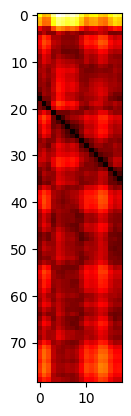

In [148]:
mfcc_reference = librosa.feature.mfcc(y=y[0:40000], sr=8000, center=True)
mfcc_reference = mfcc_reference.T
mfcc_query = mfcc_reference[18:36]
print(mfcc_reference.shape, mfcc_query.shape)
distances = cdist(mfcc_reference, mfcc_query, "euclidean")
plt.imshow(distances, cmap='hot', interpolation='nearest')

In [149]:
D, wp = librosa.sequence.dtw(mfcc_reference.T, mfcc_query.T, subseq=True)
wp

array([[35, 17],
       [34, 16],
       [33, 15],
       [32, 14],
       [31, 13],
       [30, 12],
       [29, 11],
       [28, 10],
       [27,  9],
       [26,  8],
       [25,  7],
       [24,  6],
       [23,  5],
       [22,  4],
       [21,  3],
       [20,  2],
       [19,  1],
       [18,  0]])

[(0.0, 18.0), (0.0, 2.0), Text(0.5, 1.0, 'Matching cost function')]

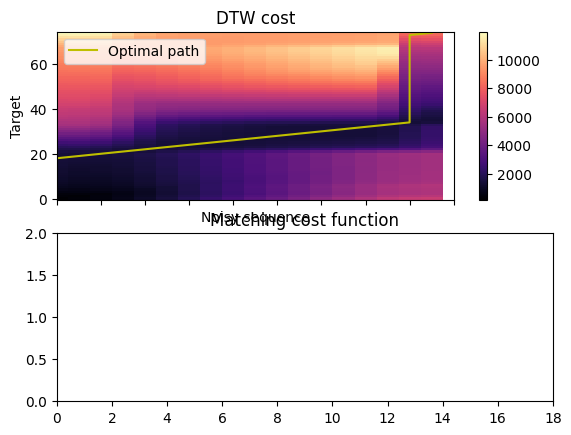

In [108]:
X = mfcc_reference.T
Y = mfcc_query.T

D, wp = librosa.sequence.dtw(X, Y)
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames',
                               ax=ax[0])
ax[0].set(title='DTW cost', xlabel='Noisy sequence', ylabel='Target')
ax[0].plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax[0].legend()
fig.colorbar(img, ax=ax[0])
ax[1].plot(D[-1, :] / wp.shape[0])
ax[1].set(xlim=[0, Y.shape[1]], ylim=[0, 2],
          title='Matching cost function')


[(0.0, 75.0), (0.0, 500.0), Text(0.5, 1.0, 'Matching cost function')]

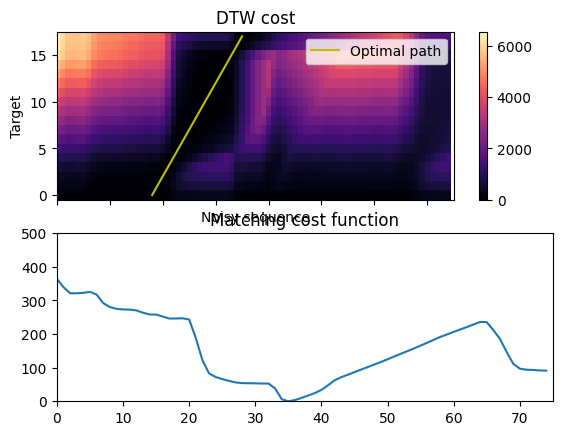

In [128]:
import numpy as np
import matplotlib.pyplot as plt
# y, sr = librosa.load(librosa.ex('brahms'), offset=10, duration=15)
# X = librosa.feature.chroma_cens(y=y, sr=sr)
X = mfcc_query.T
# noise = np.random.rand(X.shape[0], 200)
# Y = np.concatenate((noise, noise, X, noise), axis=1)
Y = mfcc_reference.T
D, wp = librosa.sequence.dtw(X, Y, subseq=True)
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames',
                               ax=ax[0])
ax[0].set(title='DTW cost', xlabel='Noisy sequence', ylabel='Target')
ax[0].plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax[0].legend()
fig.colorbar(img, ax=ax[0])
ax[1].plot(D[-1, :] / wp.shape[0])
ax[1].set(xlim=[0, Y.shape[1]], ylim=[0, 500],
          title='Matching cost function')


In [123]:
D[-1, :]

array([6563.28672178, 6112.32234056, 5787.06492882, 5786.43792569,
       5810.158542  , 5863.68237719, 5715.23988947, 5259.93291425,
       5048.4465035 , 4950.68388681, 4920.89248893, 4910.94580057,
       4869.4748451 , 4746.63248139, 4652.26041537, 4642.50302505,
       4540.18833268, 4431.48248341, 4436.06286893, 4444.97399179,
       4381.77329887, 3393.76154119, 2206.35356419, 1496.82471901,
       1299.98397013, 1187.04515064, 1092.431024  , 1012.00716925,
        973.17503401,  966.89395789,  961.10203492,  952.25673225,
        949.66067315,  684.00988226,  110.40143392,    0.        ,
         66.07160726,  183.23574806,  308.59962389,  438.57296483,
        611.16823757,  857.79780528, 1126.68426715, 1292.01595754,
       1423.39596538, 1559.6695009 , 1697.72007617, 1833.52812931,
       1968.49910389, 2106.71126431, 2249.30966189, 2399.41237123,
       2544.14710429, 2686.79891994, 2834.31348943, 2983.83183367,
       3138.58701057, 3296.24841119, 3451.14590079, 3582.09035

In [132]:
end_index = np.argmin(D[-1, :])
print(end_index)
D[-1, end_index]

35


0.0

In [133]:
D.shape

(18, 75)

In [120]:
mfcc_reference.T.shape, mfcc_query.T.shape

((20, 75), (20, 18))